# Interactive CPPI Monte Carlo Testing

## Random Walk Generation

The stochastic model for asset returns is given by the Geometric Brownian Motion process:

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

When we generate simulated returns, we can usually ignore the decomposition of $\mu$ since we only care about the net effective drift term without worrying about what the components of it are.

In [33]:
def gbm2(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    prices = s_0*pd.DataFrame(rets_plus_1).cumprod()
    return prices

In [35]:
gbm2(n_years=10, n_scenarios=10000, mu=0.07, steps_per_year=12).iloc[-1].mean(), 100*1.07**10

(198.31893086896906, 196.71513572895665)

<Axes: >

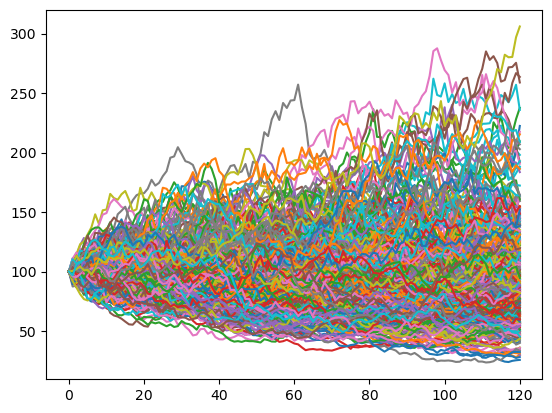

In [42]:
gbm2(n_years=10, n_scenarios=300, mu=0.00, steps_per_year=12).plot(legend=False)

# Interactive Plotting and Monte Carlo Simulations of CPPI

In [13]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import edhec_risk_kit_124 as erk

%load_ext autoreload
%autoreload 2

## GBM Simulations

In [16]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    s_0=100
    prices = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax = prices.plot(legend=False, color="indianred", alpha = 0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=s_0, ls=":", color="black")
    # draw a dot at the origin
    ax.plot(0,s_0, marker='o',color='darkred', alpha=0.2)


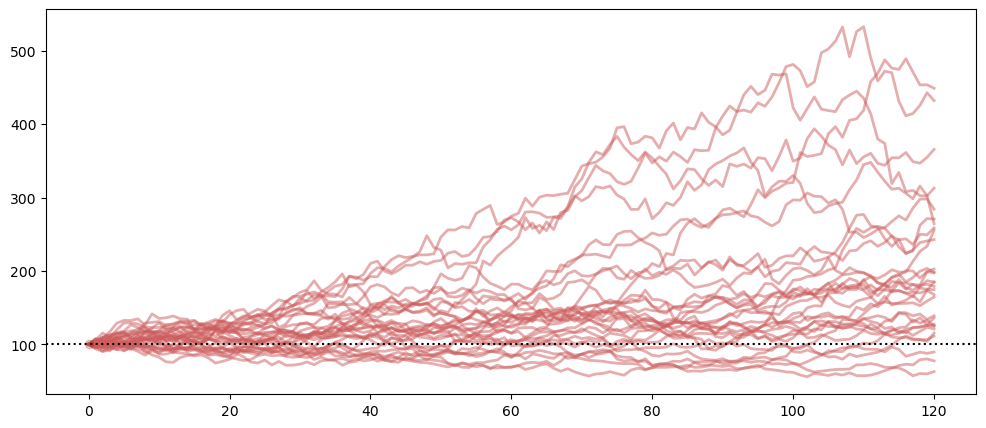

In [18]:
show_gbm(30,0.07,0.15)

# Interactive CPPI Monte Carlo Testing

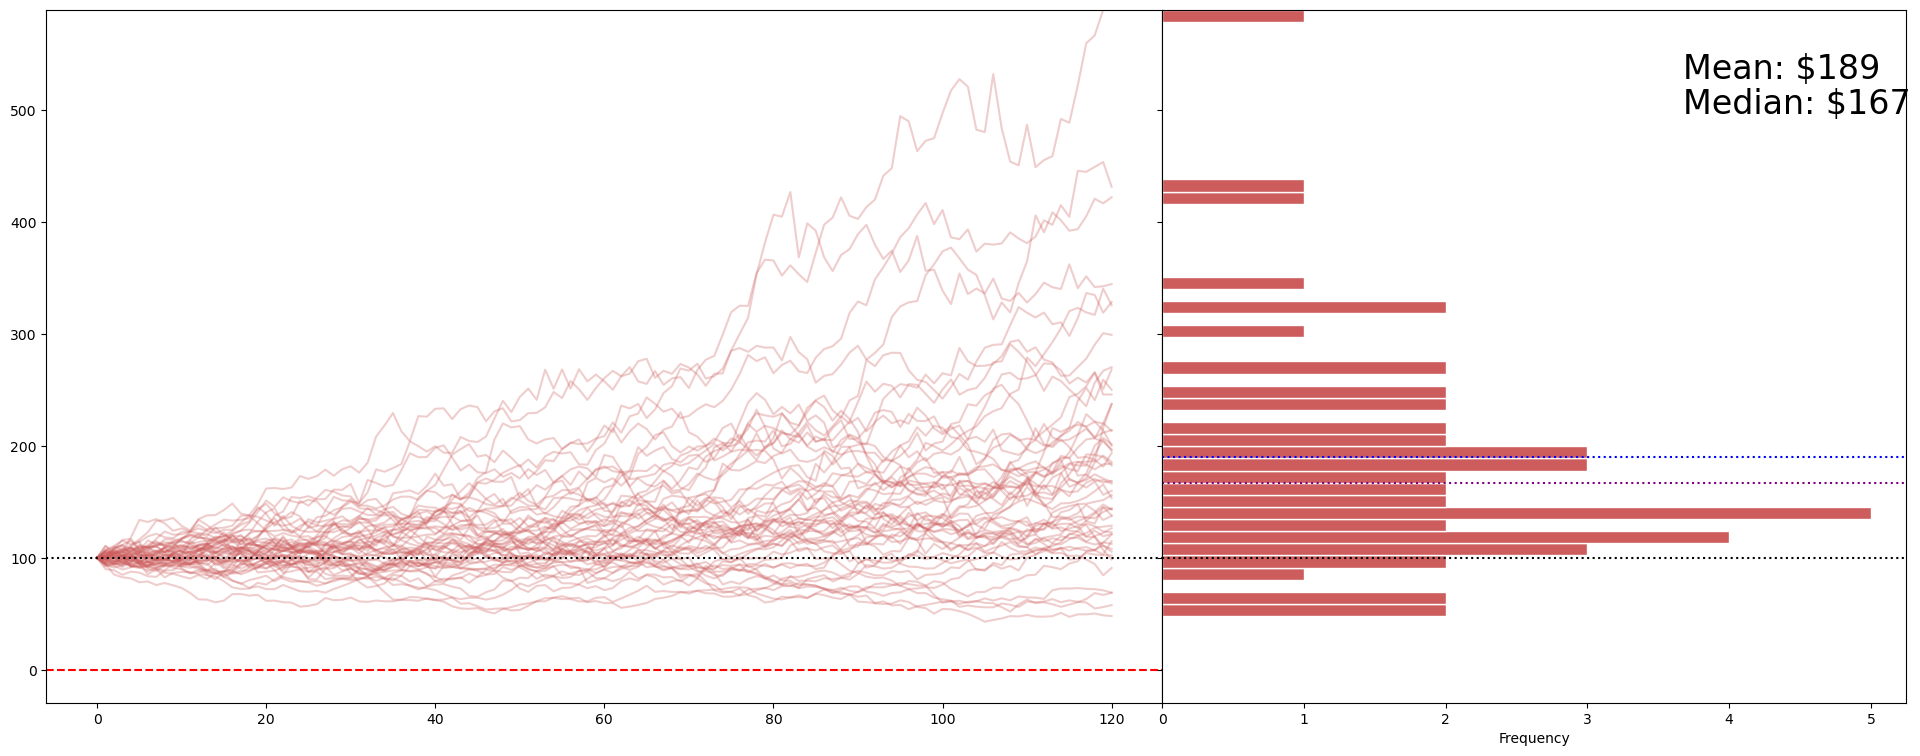

In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, steps_per_year=12, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=steps_per_year)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]

    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

show_cppi()

In [46]:
# To enable the interactive controls of the widgets, remove the following hashes:

# cppi_controls = widgets.interactive(show_cppi,
#                                    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
#                                    mu=(0., +.2, .01),
#                                    sigma=(0, .3, .05),
#                                    floor=(0, 2, .1),
#                                    m=(1, 5, .5),
#                                    riskfree_rate=(0, .05, .01),
#                                    steps_per_year=widgets.IntSlider(min=1, max=12, step=1, value=12,
#                                                           description="Rebals/Year"),
#                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
#                                                           description="Zoom Y Axis")
# )
# display(cppi_controls)